In [1]:
import pandas as pd
import numpy as np
import perception.util.conversion as conv
import os
import cv2
import scipy
import math
import seaborn as sns
import importlib
import statsmodels.api as sm
import ground_truth_real

from ground_truth_real import GroundTruthMeasurements
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.interpolate import UnivariateSpline
from scipy.stats import normaltest

from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import PchipInterpolator
import perception.util.aruco as aruco

plt.style.use("seaborn-v0_8")
sns.set_palette(sns.color_palette("colorblind"))

In [6]:
importlib.reload(ground_truth_real)

<module 'ground_truth_real' from '/media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/ground_truth_real.py'>

In [7]:
experiments_dir = f'{os.getcwd()}/../../../../perception_debug'
figures_dir = f'{os.getcwd()}/../../../../figures'
run1_path = f'{experiments_dir}/run1'
run2_path = f'{experiments_dir}/run2'
run3_path = f'{experiments_dir}/run3'

bev_paths_run1 = [f'{run1_path}/bev/{f}' for f in os.listdir(f'{run1_path}/bev') if os.path.isdir(f'{run1_path}/bev/{f}')]
bev_paths_run2 = [f'{run2_path}/bev/{f}' for f in os.listdir(f'{run2_path}/bev') if os.path.isdir(f'{run2_path}/bev/{f}')]
bev_paths_run3 = [f'{run3_path}/bev/{f}' for f in os.listdir(f'{run3_path}/bev') if os.path.isdir(f'{run3_path}/bev/{f}')]

tracking_paths_run1 = [f'{run1_path}/ego/{f}/color' for f in os.listdir(f'{run1_path}/ego') if os.path.isdir(f'{run1_path}/ego/{f}')]
tracking_paths_run2 = [f'{run2_path}/ego/{f}/color' for f in os.listdir(f'{run2_path}/ego') if os.path.isdir(f'{run2_path}/ego/{f}')]
tracking_paths_run3 = [f'{run3_path}/ego/{f}/color' for f in os.listdir(f'{run3_path}/ego') if os.path.isdir(f'{run3_path}/ego/{f}')]

RUN1_2_MEASUREMENTS = GroundTruthMeasurements(
  bev_to_cam_ego_x=-184.8,
  bev_to_cam_ego_y=-39.5,
  bev_to_cam_ego_z=12.5,
  bev_to_back_opp_x=-100.0,
  bev_to_back_opp_y=0.0,
  bev_to_back_opp_z=-120.0,
  ego_top_marker_to_ego_cam_rot=conv.get_rotation_matrix_from_euler(-90, 0, 90, degrees=True),
  opp_top_marker_to_opp_back_marker_rot=conv.get_rotation_matrix_from_euler(-90, 90, 90, degrees=True),
)

RUN3_MEASUREMENTS = GroundTruthMeasurements(
  bev_to_cam_ego_x=-28.7,
  bev_to_cam_ego_y=376.0,
  bev_to_cam_ego_z=-94.9,
  bev_to_back_opp_x=-157.0,
  bev_to_back_opp_y=0.0,
  bev_to_back_opp_z=-116.0,
  ego_top_marker_to_ego_cam_rot=conv.get_rotation_matrix_from_euler(-90, 0, 0, degrees=True),
  opp_top_marker_to_opp_back_marker_rot=conv.get_rotation_matrix_from_euler(-90, 90, 90, degrees=True),
)

In [8]:
side_length = 0.25
half_side_length = side_length / 2

# Define the 4 corners of the ArUco marker
marker_obj_points = np.array([[
    [-half_side_length, half_side_length, 0],
    [half_side_length, half_side_length, 0],
    [half_side_length, -half_side_length, 0],
    [-half_side_length, -half_side_length, 0]
]], dtype=np.float32)

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_APRILTAG

In [12]:
importlib.reload(ground_truth_real)

<module 'ground_truth_real' from '/media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts/ground_truth_real.py'>

In [23]:
from perception.scripts.ground_truth_real import SmoothingParams

smoothing_funcs = ["lowess"]
run1_data = ground_truth_real.process_run_data(
    ground_truth_real.read_all_runs(bev_paths_run1, tracking_paths_run1),
    RUN1_2_MEASUREMENTS,
    smoothing_funcs,
)

run2_data = ground_truth_real.process_run_data(
    ground_truth_real.read_all_runs(bev_paths_run2, tracking_paths_run2),
    RUN1_2_MEASUREMENTS,
    smoothing_funcs,
    [[
        SmoothingParams(lowess_frac=50, lowess_it=3),
        SmoothingParams(lowess_frac=70, lowess_it=1),
        SmoothingParams(lowess_frac=40, lowess_it=1),
        SmoothingParams(lowess_frac=60, lowess_it=1),
        SmoothingParams(lowess_frac=70, lowess_it=1),
        SmoothingParams(lowess_frac=70, lowess_it=1),
    ] for _ in range(len(bev_paths_run2))],
)

run3_data = ground_truth_real.process_run_data(
    ground_truth_real.read_all_runs(bev_paths_run3, tracking_paths_run3),
    RUN3_MEASUREMENTS,
    smoothing_funcs,
    [[
        SmoothingParams(lowess_frac=15, lowess_it=3),
        SmoothingParams(lowess_frac=30, lowess_it=1),
        SmoothingParams(lowess_frac=15, lowess_it=1),
        SmoothingParams(lowess_frac=10, lowess_it=1),
        SmoothingParams(lowess_frac=30, lowess_it=1),
        SmoothingParams(lowess_frac=30, lowess_it=1),
    ] for _ in range(len(bev_paths_run3))],
)

## Time AruCo marker refinement method

In [10]:
run_num = 0
num = 1

image = cv2.imread(f'{experiments_dir}/run3/bev/24_09_29_23:35:44/bev/right/1727606147480088612.png')
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

intrinsics = np.loadtxt(f'{experiments_dir}/run3/bev/24_09_29_23:35:44/bev/right/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{experiments_dir}/run3/bev/24_09_29_23:35:44/bev/right/dist_coeffs.txt')
detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)

new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)

# time the detection process
repeats = 100
total_time = 0
for _ in range(repeats):
  aruco_start = cv2.getTickCount()
  und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)
  aruco_end = cv2.getTickCount()
  total_time += (aruco_end - aruco_start) / cv2.getTickFrequency()

avg_total_time = total_time / repeats
avg_total_time, total_time

(0.004530339810000001, 0.45303398100000003)

### Show the image from the BEV camera

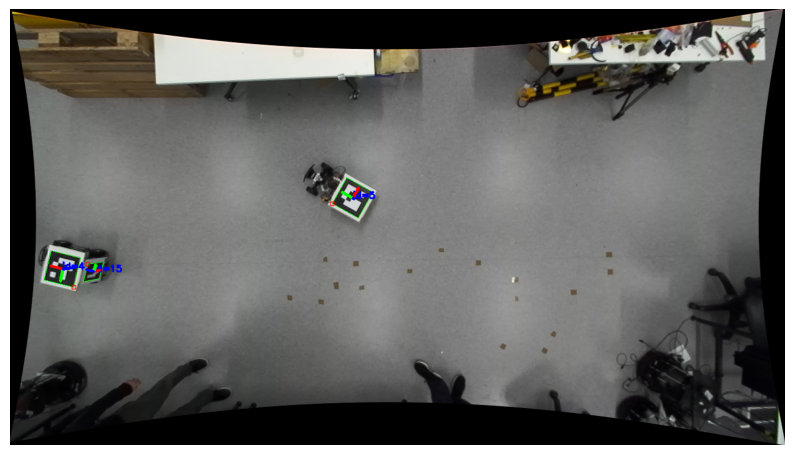

In [6]:
run_data = run3_data
run_num = 0
num = -1
image_prev = cv2.imread(f'{run_data[run_num]["bev_path"]}/bev/right/{run_data[run_num]["ego_bev_right_df"]["time"].iloc[num - 1]}.png')

image = cv2.imread(f'{run_data[run_num]["bev_path"]}/bev/right/{run_data[run_num]["ego_bev_right_df"]["time"].iloc[num]}.png')
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

intrinsics = np.loadtxt(f'{run_data[run_num]["bev_path"]}/bev/right/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{run_data[run_num]["bev_path"]}/bev/right/dist_coeffs.txt')
detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_APRILTAG

def draw_tracking_on_image(image, intrinsics, dist_coeffs):
  new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
  undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)
  und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)

  drawn_image = cv2.aruco.drawDetectedMarkers(undistorted_image.copy(), und_corners, und_ids)

  for corner, id in zip(und_corners, und_ids):
    _, rvecs_und, tvecs_und, reproj_error = cv2.solvePnPGeneric(marker_obj_points, corner, new_intrinsics, None, flags=cv2.SOLVEPNP_IPPE_SQUARE)
    for rvec_und, tvec_und in zip(rvecs_und, tvecs_und):
      # rvec_und = conv.get_rodrigues_from_euler(45,0,0, degrees=True)
      # rvec_und = conv.get_rodrigues_from_euler(20, 20, 20, degrees=True)
      quat = conv.get_quaternion_from_rodrigues(rvec_und)
      euler_und = conv.get_euler_from_quaternion(*quat, degrees=True)
    
    cv2.drawFrameAxes(drawn_image, new_intrinsics, None, rvec_und, tvec_und, 0.1)
  
  return drawn_image

drawn_image = draw_tracking_on_image(image, intrinsics, dist_coeffs)
drawn_image_prev = draw_tracking_on_image(image_prev, intrinsics, dist_coeffs)

plt.figure(figsize=(10, 10))
plt.grid(False)
plt.axis('off')
plt.imshow(cv2.cvtColor(drawn_image, cv2.COLOR_BGR2RGB))

## Show the image from the egovehicle camera

[[ 0.16153777]
 [-0.01028541]
 [ 0.82055154]] (-163.54945019410195, 1.4328629131943147, 88.34352808852685) [1.76705]


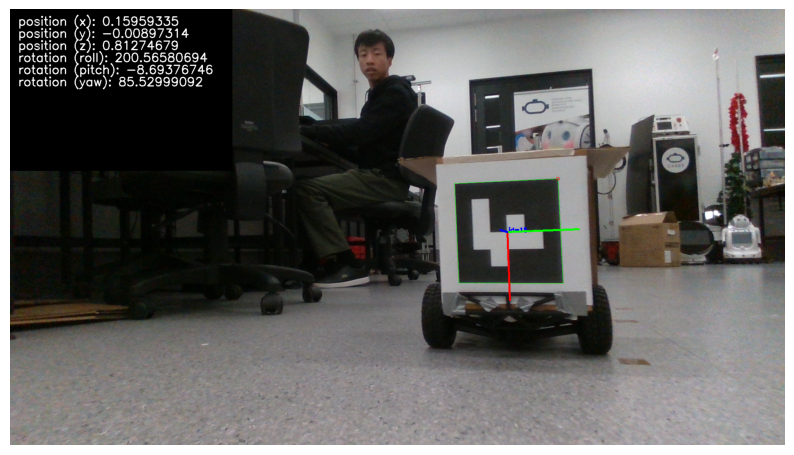

In [27]:
run_num = 6
run = run3_data[run_num]
num = 32
state_est_method = "tracking_df"
back_marker_id = 15

time = run["tracking_df"]["time"].iloc[num]
# get closest time in state estimation data
time_closest = run[state_est_method]["time"].iloc[(run[state_est_method]["time"] - time).abs().argsort()[:1].values[0]]

image = cv2.imread(f'{run["ego_path"]}/{run["tracking_df"]["time"].iloc[num]}.png')
# image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

intrinsics = np.loadtxt(f'{run["ego_path"]}/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{run["ego_path"]}/dist_coeffs.txt')

detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX

def draw_tracking_on_image(image, intrinsics, dist_coeffs, marker_size):
  side_length = marker_size
  half_side_length = side_length / 2

  # Define the 4 corners of the ArUco marker
  marker_obj_points = np.array([[
      [-half_side_length, half_side_length, 0],
      [half_side_length, half_side_length, 0],
      [half_side_length, -half_side_length, 0],
      [-half_side_length, -half_side_length, 0]
  ]], dtype=np.float32)

  new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
  undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)
  und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)
  
  back_ids = np.array([und_ids[i] for i in range(len(und_ids)) if und_ids[i][0] == back_marker_id])
  back_corners = np.array([und_corners[i] for i in range(len(und_corners)) if und_ids[i][0] == back_marker_id])
  
  drawn_image = cv2.aruco.drawDetectedMarkers(undistorted_image.copy(), back_corners, back_ids)

  font = cv2.FONT_HERSHEY_SIMPLEX
  fontScale = 1
  fontColor = (255, 255, 255)
  lineType = 2
  
  # put border around text
  cv2.rectangle(drawn_image, (0, 0), (550, 400), (0,0,0), -1)

  state = {
    "tx": {"common_name": "position (x)"},
    "ty": {"common_name": "position (y)"},
    "tz": {"common_name": "position (z)"},
    "roll": {"common_name": "rotation (roll)"},
    "pitch": {"common_name": "rotation (pitch)"},
    "yaw": {"common_name": "rotation (yaw)"},
    # "vx": {"common_name": "velocity (x)"},
    # "vy": {"common_name": "velocity (y)"},
    # "vz": {"common_name": "velocity (z)"},
    # "vroll": {"common_name": "angular velocity (roll)"},
    # "vpitch": {"common_name": "angular velocity (pitch)"},
    # "vyaw": {"common_name": "angular velocity (yaw)"},
    # "ax": {"common_name": "acceleration (x)"},
    # "ay": {"common_name": "acceleration (y)"},
    # "az": {"common_name": "acceleration (z)"},
    # "aroll": {"common_name": "angular acceleration (roll)"},
    # "apitch": {"common_name": "angular acceleration (pitch)"},
    # "ayaw": {"common_name": "angular acceleration (yaw)"},

  }

  for var in state.keys():
    state[var]["val"] = run[state_est_method][run[state_est_method]["time"] == time_closest][var].values[0]
    # reduce float precision
    state[var]["val"] = round(state[var]["val"], 8)
  
  for i, var in enumerate(state.keys()):
    
    cv2.putText(drawn_image, f'{state[var]["common_name"]}: {state[var]["val"]}', (20, 40 + i * 30), font, fontScale, fontColor, lineType)

  for corner, id in zip(back_corners, back_ids):
    _, rvec, tvec = cv2.solvePnP(marker_obj_points, corner, new_intrinsics, None, flags=cv2.SOLVEPNP_SQPNP)
    # solvepnpgeneric
    _, rvecs, tvecs, reproj_error = cv2.solvePnPGeneric(marker_obj_points, corner, new_intrinsics, None, flags=cv2.SOLVEPNP_SQPNP)
    for rvec, tvec, err in zip(rvecs, tvecs, reproj_error):
      quat = conv.get_quaternion_from_rodrigues(rvec)
      euler = conv.get_euler_from_quaternion(*quat, degrees=True)
      print(tvec, euler, err)
  
    cv2.drawFrameAxes(drawn_image, new_intrinsics, None, rvec, tvec, 0.1)
  
  return undistorted_image, drawn_image

undistorted_image, drawn_image = draw_tracking_on_image(image, intrinsics, dist_coeffs, 0.15)

cv2.imwrite(f'{figures_dir}/tracking_raw.png', undistorted_image)
cv2.imwrite(f'{figures_dir}/tracking_on_image.png', drawn_image)

plt.figure(figsize=(10, 10))
plt.grid(False)
plt.axis('off')
plt.imshow(cv2.cvtColor(drawn_image, cv2.COLOR_BGR2RGB))

## Polynomial fitting

### Lack of robustness to cross-validation

[-2.27653597e+04  9.98109011e-01  9.92347931e-01  9.17997393e-01
 -1.66234499e+04]


<AxesSubplot: title={'center': 'Cross-validation on polynomial regression'}, xlabel='Time (s)', ylabel='tx'>

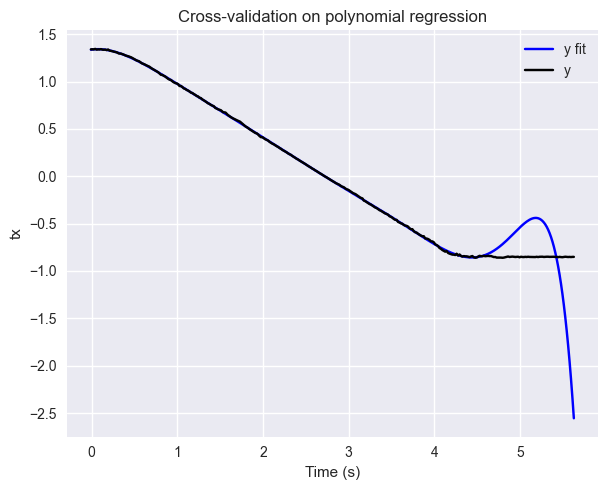

In [114]:
models = []

degree = 10
run_data = run1_data
run_num = 0
folds = 5
displayed_model = 4

class SMWrapper(BaseEstimator, RegressorMixin):
  """ A universal sklearn-style wrapper for statsmodels regressors """
  def __init__(self, model_class, degree=10):
    self.model_class = model_class
    self.degree = degree
    
  def fit(self, X, y):
    self.model_, _, _ = ground_truth_real.fit_polynomial(X, y, self.degree)
    models.append(self.model_)
    return self
  
  def predict(self, X: np.ndarray):
    polynomial_features= PolynomialFeatures(degree=self.degree)
    X = X.reshape(-1, 1)
    xp = polynomial_features.fit_transform(X)
    
    return np.polyval(self.model_, X)
  
cross_val_wrapper = SMWrapper(sm.OLS, degree=degree)
print(cross_val_score(cross_val_wrapper,
                run_data[run_num]["raw"]["ego_bev_right_df"]["time_norm (sec)"].values, 
                run_data[run_num]["raw"]["ego_bev_right_df"]["tx"], scoring='r2', cv=folds))

# Show cross-validation results
plt.figure(figsize=(6, 5))
polynomial_features= PolynomialFeatures(degree=degree)
x = run_data[run_num]["raw"]["ego_bev_right_df"]['time_norm (sec)'].values
# xp = polynomial_features.fit_transform(x)

plt.xlabel('Time (s)')
plt.title('Cross-validation on polynomial regression')
plt.tight_layout()

sns.lineplot(x=x.flatten(), y=np.polyval(models[displayed_model], x), label='y fit', color='blue')
sns.lineplot(data=run_data[run_num]["raw"]["ego_bev_right_df"], x='time_norm (sec)', y='tx', label='y', color='black')

### Compare WLS and OLS fit using the Monte Carlo variances as weights

In [103]:
# get polynomial features
degree = 20
run_num = 6
run = run3_data[run_num]
quantity = "tz"
smoothing_type = "raw"
cam = "right"
polynomial_features= PolynomialFeatures(degree=degree)
x = run3_data[run_num][smoothing_type][f"rel_poses_{cam}_df"]['time_norm (sec)'].values.reshape(-1, 1)
xp = polynomial_features.fit_transform(x)

# fit polynomial with WLS
weights = 1 / (run[f"monte_carlo_{cam}_df"][f"{quantity}_std"].values ** 2)
# normalise weights
weights /= np.max(weights)

model = sm.WLS(run[smoothing_type][f"rel_poses_{cam}_df"][quantity].values,
                xp, weights=weights).fit()
# ols model to compare
ols_model = sm.OLS(run[smoothing_type][f"rel_poses_{cam}_df"][quantity].values, xp).fit()

<AxesSubplot: title={'center': 'WLS fit vs OLS fit'}, xlabel='Time (s)', ylabel='tz'>

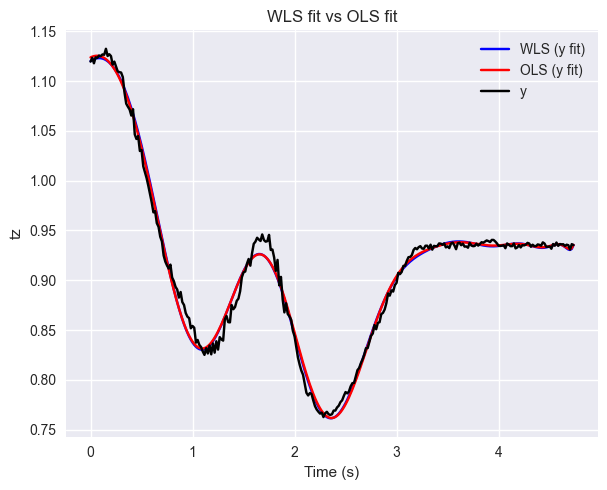

In [82]:
# plot wls fit
plt.figure(figsize=(6, 5))
plt.xlabel('Time (s)')
plt.title('WLS fit vs OLS fit')
plt.tight_layout()

sns.lineplot(x=x.flatten(), y=model.predict(xp), label='WLS (y fit)', color='blue')
sns.lineplot(x=x.flatten(), y=ols_model.predict(xp), label='OLS (y fit)', color='red')
sns.lineplot(data=run3_data[run_num]["raw"]["rel_poses_right_df"], x='time_norm (sec)', y=quantity, label='y', color='black')

### Make residual plots for regression models

/media/rl16432/Shared/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


NormaltestResult(statistic=18.091142989256042, pvalue=0.00011791205657440296)

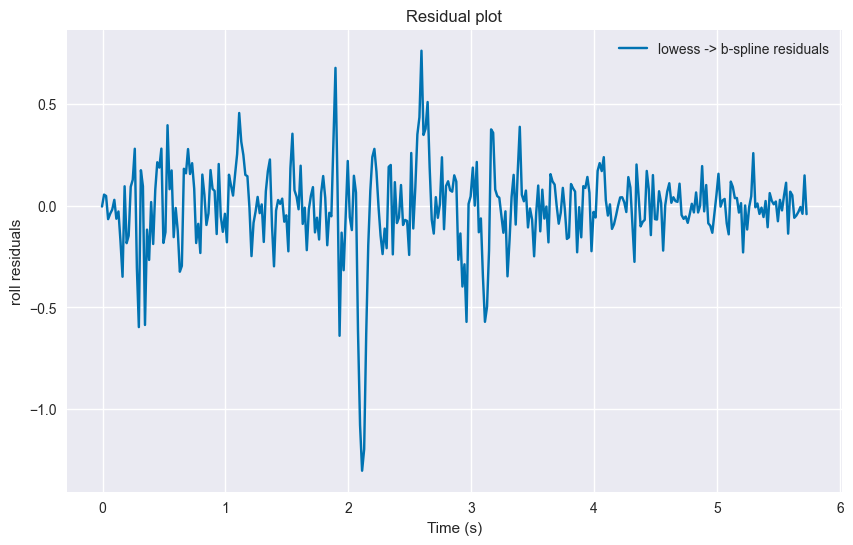

In [25]:
smoothing_type = "raw"
cam = "right"
run_num = 5
df = run3_data[run_num][smoothing_type][f"rel_poses_{cam}_df"]
monte_carlo_df = run3_data[run_num][f"monte_carlo_{cam}_df"]

col_name = "roll"
lowess_window = 15

tx_poly, vx_poly, ax_poly = ground_truth_real.fit_polynomial(
  df["time_norm (sec)"].values, 
  df[col_name], 10)
poly_resid = np.polyval(tx_poly, df["time_norm (sec)"]) - df[col_name]

tx_lowess = lowess(df[col_name], df["time_norm (sec)"], frac = lowess_window / len(df), it = 1)[:, 1]
lowess_resid = df[col_name] - tx_lowess

# tx_lowess_5 = lowess(df[col_name], df["time_norm (sec)"], frac = 5 / len(df), it = 1)[:, 1]
# lowess_5_resid = df[col_name] - tx_lowess_5

tx_savgol = scipy.signal.savgol_filter(df[col_name], 20, 3)
savgol_resid = df[col_name] - tx_savgol

tx_arima = sm.tsa.ARIMA(df[col_name], df["time_norm (sec)"], order=(5, 0, 1)).fit()
arima_resid = tx_arima.resid

tx_pchip = PchipInterpolator(df["time_norm (sec)"], df[col_name])
pchip_resid = df[col_name] - tx_pchip(df["time_norm (sec)"])

tx_pchip_lowess = PchipInterpolator(df["time_norm (sec)"], tx_lowess)
pchip_lowess_resid = df[col_name] - tx_pchip_lowess(df["time_norm (sec)"])

# tx_univariate = UnivariateSpline(df["time_norm (sec)"], df[col_name], k=1, s=0.01)
tx_univariate = UnivariateSpline(df["time_norm (sec)"], df[col_name], k=3, s=len(df) * 0.15)
univariate_resid = df[col_name] - tx_univariate(df["time_norm (sec)"])

tx_univariate_lowess = UnivariateSpline(df["time_norm (sec)"], tx_lowess, k=3, s=0)
univariate_lowess_resid = df[col_name] - tx_univariate_lowess(df["time_norm (sec)"])

plt.figure(figsize=(10, 6))
plt.title(f'Residual plot')
plt.ylabel(f'{col_name} residuals')
plt.xlabel('Time (s)')
# sns.lineplot(x=df["time_norm (sec)"], y=lowess_resid, label='lowess_residuals')
# sns.lineplot(x=df["time_norm (sec)"], y=savgol_resid, label='savgol_residuals')
# sns.lineplot(x=df["time_norm (sec)"], y=poly_resid, label='poly residuals (d=10)')
# sns.lineplot(x=df["time_norm (sec)"], y=pchip_resid, label='pchip_residuals')
# sns.lineplot(x=df["time_norm (sec)"], y=univariate_resid, label='b-spline residuals (s=0.025)')
# sns.lineplot(x=df["time_norm (sec)"], y=pchip_lowess_resid, label='lowess -> pchip residuals')
sns.lineplot(x=df["time_norm (sec)"], y=univariate_lowess_resid, label='lowess -> b-spline residuals')

normaltest(poly_resid)

### Make pose plots for regression models

<AxesSubplot: title={'center': 'x position vs time'}, xlabel='Time (s)', ylabel='Position (m)'>

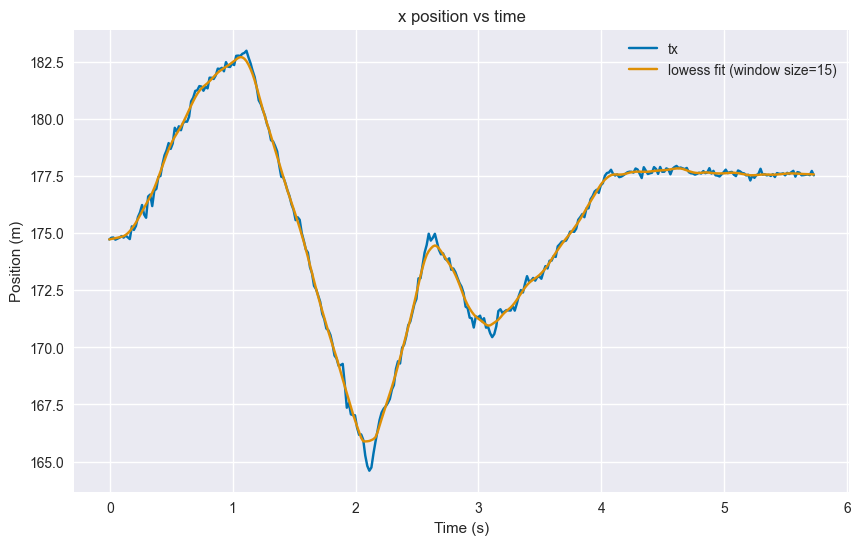

In [26]:
from toleranceinterval import twoside

k = twoside.normal_factor(1000, 0.95, 0.95)
plt.figure(figsize=(10, 6))
plt.title(f'x position vs time')
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')
sns.lineplot(x=df["time_norm (sec)"], y=df[col_name], label='tx')
# sns.lineplot(x=df["time_norm (sec)"], y=np.polyval(tx_poly, df["time_norm (sec)"]), label='poly fit (d=10)')
# sns.lineplot(x=df["time_norm (sec)"], y=tx_pchip(df["time_norm (sec)"]), label='pchip fit')
sns.lineplot(x=df["time_norm (sec)"], y=tx_lowess, label=f'lowess fit (window size={lowess_window})')
# sns.lineplot(x=df["time_norm (sec)"], y=tx_univariate_lowess(df["time_norm (sec)"]), label='b-spline fit (s=0.025)')
# plt.fill_between(df["time_norm (sec)"], tx_lowess - k * monte_carlo_df[f"{col_name}_std"],
#                   tx_lowess + k * monte_carlo_df[f"{col_name}_std"], alpha=0.5)

### Make velocity plots for regression models

<AxesSubplot: title={'center': 'Ground truth velocity from fitted models'}, xlabel='Time (s)', ylabel='Velocity (m/s)'>

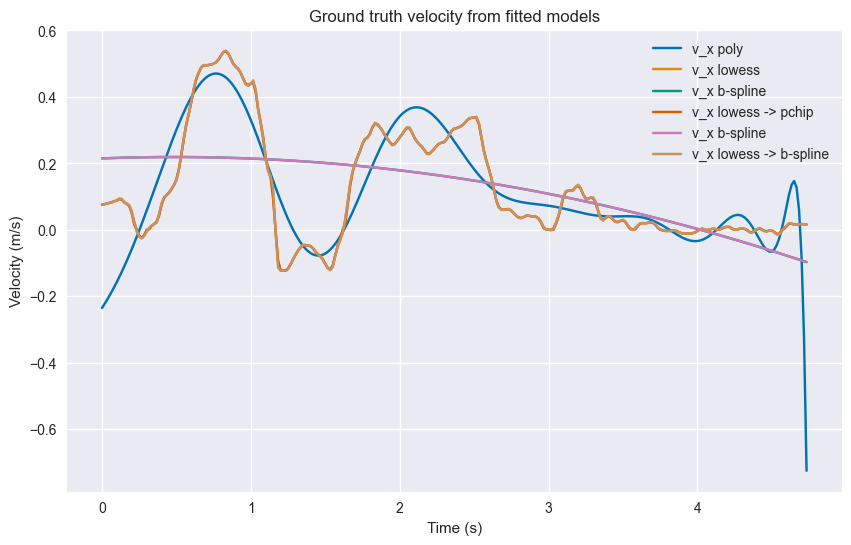

In [122]:
plt.figure(figsize=(10, 6))
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
plt.title("Ground truth velocity from fitted models")

# sns.lineplot(x=df["time_norm (sec)"], y=np.gradient(tx_savgol, df["time_norm (sec)"]), label='v_x savgol')
sns.lineplot(x=df["time_norm (sec)"], y=np.polyval(vx_poly, df["time_norm (sec)"]), label='v_x poly')
# sns.lineplot(x=df["time_norm (sec)"], y=tx_pchip.derivative()(df["time_norm (sec)"]), label='v_x pchip')
sns.lineplot(x=df["time_norm (sec)"], y=np.gradient(tx_lowess, df["time_norm (sec)"]), label='v_x lowess')
sns.lineplot(x=df["time_norm (sec)"], y=tx_univariate.derivative()(df["time_norm (sec)"]), label='v_x b-spline')
sns.lineplot(x=df["time_norm (sec)"], y=tx_pchip_lowess.derivative()(df["time_norm (sec)"]), label='v_x lowess -> pchip')
sns.lineplot(x=df["time_norm (sec)"], y=tx_univariate.derivative()(df["time_norm (sec)"]), label='v_x b-spline')
sns.lineplot(x=df["time_norm (sec)"], y=tx_univariate_lowess.derivative()(df["time_norm (sec)"]), label='v_x lowess -> b-spline')

### Make velocity plots for polynomials of different degrees

<AxesSubplot: title={'center': 'Computed velocity (m/s) from polynomial regression of varying degrees'}, xlabel='Time (s)', ylabel='Velocity (m/s)'>

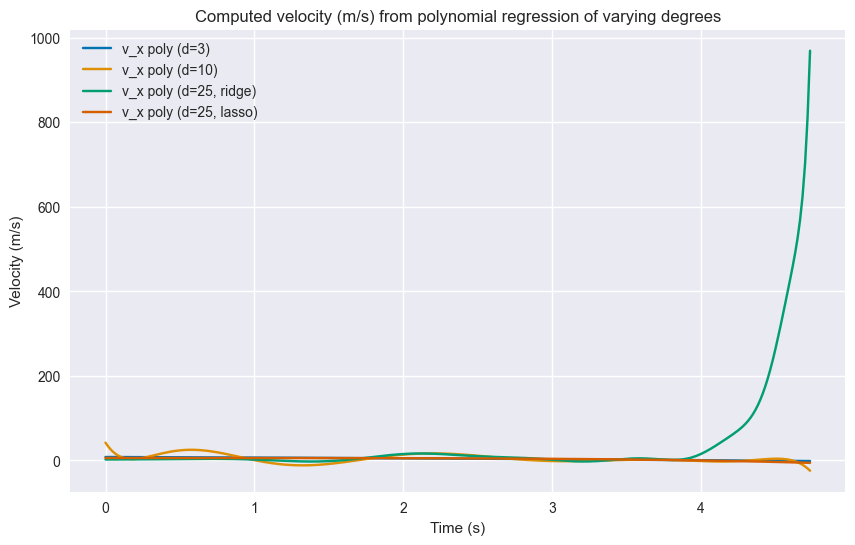

In [138]:
tx_poly_3, vx_poly_3, ax_poly_3 = ground_truth_real.fit_polynomial(
  df["time_norm (sec)"].values, 
  df[col_name], 3)

tx_poly_10, vx_poly_10, ax_poly_10 = ground_truth_real.fit_polynomial(
  df["time_norm (sec)"].values, 
  df[col_name], 10)

tx_poly_25_ridge, vx_poly_25_ridge, ax_poly_25_ridge = ground_truth_real.fit_polynomial(
  df["time_norm (sec)"].values, 
  df[col_name], 25, regularise=True, L1_wt=0)

tx_poly_25_l1, vx_poly_25_l1, ax_poly_25_l1 = ground_truth_real.fit_polynomial(
  df["time_norm (sec)"].values, 
  df[col_name], 25, regularise=True, L1_wt=1)

plt.figure(figsize=(10, 6))
plt.title('Computed velocity (m/s) from polynomial regression of varying degrees')
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time (s)')
sns.lineplot(x=df["time_norm (sec)"], y=np.polyval(vx_poly_3, df["time_norm (sec)"]), label='v_x poly (d=3)')
sns.lineplot(x=df["time_norm (sec)"], y=np.polyval(vx_poly_10, df["time_norm (sec)"]), label='v_x poly (d=10)')
sns.lineplot(x=df["time_norm (sec)"], y=np.polyval(vx_poly_25_ridge, df["time_norm (sec)"]), label='v_x poly (d=25, ridge)')
sns.lineplot(x=df["time_norm (sec)"], y=np.polyval(vx_poly_25_l1, df["time_norm (sec)"]), label='v_x poly (d=25, lasso)')


## Piecewise model attempts

### Situation where piecewise model may be appropriate

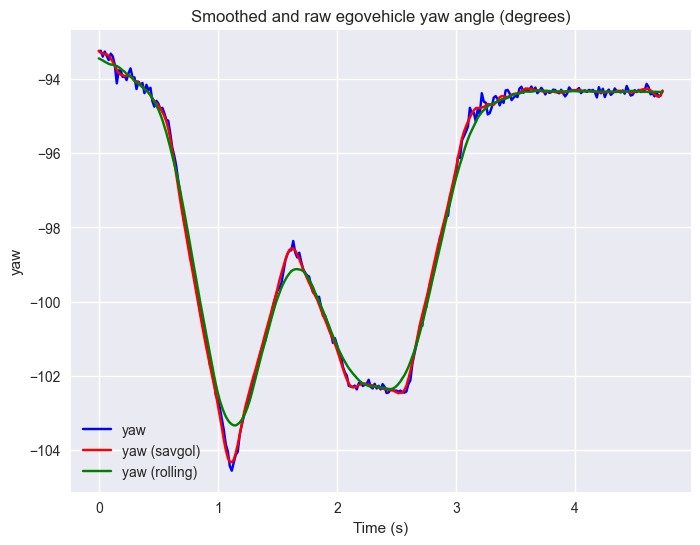

In [145]:
# plot the x and y positions
df = run3_data[6]
df_name = "ego_bev_right_df"

def plot_smoothed_data(run: dict, df_name: str, x_col: str, y_col: str):
  sns.lineplot(data=run["raw"][f"{df_name}"], x=x_col, y=f"{y_col}", label=y_col, color='blue')
  sns.lineplot(data=run["savgol"][f"{df_name}"], x=x_col, y=f"{y_col}", label=f"{y_col} (savgol)", color='red')
  sns.lineplot(data=run["rolling"][f"{df_name}"], x=x_col, y=f"{y_col}", label=f"{y_col} (rolling)", color='green')

def plot_all_smoothed_poses(run: dict, df_name, x_col: str, columns: list[str], title: str, figsize=(8, 6)):
  fig = plt.figure(figsize=figsize)
  for i, col in enumerate(columns):
    plt.subplot(len(columns), 1, i + 1)
    plt.xlabel("Time (s)")
    if i == 0:
      plt.title(title)
    plot_smoothed_data(run, df_name, x_col, col)

plot_all_smoothed_poses(df, df_name, "time_norm (sec)", ["yaw"], "Smoothed and raw egovehicle yaw angle (degrees)")